In [3]:
from google.colab import drive

import os

In [4]:
# grab dataset from google drive
drive.mount('/content/drive')
!cp '/content/drive/MyDrive/test_x.sdf' 'test_x.sdf'
!cp '/content/drive/MyDrive/train.sdf' 'train.sdf'

Mounted at /content/drive


## Read SDF format data (structured-data format)

In [5]:
import numpy as np
from tqdm.notebook import tqdm

# create function to read file
def read_sdf(file):
    # open file for reading 'r'
    with open(file, 'r') as rf:
        # saving the contents after reading the file
        content = rf.read()
        # split the content based on given string
    samples = content.split('$$$$')
    
    # function to break down the content
    def parse_sample(s):
        # splits strings into a list where each line is a list item
        lines = s.splitlines()
        # creates empty lists for links and nodes
        links = []
        nodes = []
        label = 0
        for l in lines:
            if l.strip() == '1.0':
                label = 1
            if l.strip() == '-1.0':
                label = 0
            if l.startswith('    '):
                feature = l.split()
                node = feature[3]
                nodes.append(node)
            elif l.startswith(' '):
                lnk = l.split()
                # edge: (from, to,) (1-based index)
                if int(lnk[0]) - 1 < len(nodes):
                    links.append((
                        int(lnk[0])-1, 
                        int(lnk[1])-1, # zero-based index
                        # int(lnk[2]) ignore edge weight
                    ))
        return nodes, np.array(links), label
    
    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0]
                
        
        

In [6]:
from sklearn.model_selection import train_test_split

training_set = read_sdf('train.sdf')
training_set, validation_set = train_test_split(training_set, test_size=0.15,)

In [7]:
testing_set  = read_sdf('test_x.sdf')

In [21]:
print(testing_set[1])

(['O', 'O', 'O', 'O', 'O', 'O', 'N', 'N', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C'], array([[ 0,  8],
       [ 0, 11],
       [ 1, 11],
       [ 2, 14],
       [ 3, 16],
       [ 4, 25],
       [ 5, 25],
       [ 6,  8],
       [ 6, 10],
       [ 7,  9],
       [ 7, 14],
       [ 8,  9],
       [ 9, 12],
       [10, 11],
       [10, 15],
       [12, 13],
       [13, 16],
       [13, 18],
       [14, 17],
       [15, 19],
       [16, 20],
       [17, 21],
       [17, 22],
       [18, 23],
       [19, 25],
       [20, 24],
       [21, 26],
       [22, 27],
       [23, 24],
       [26, 28],
       [27, 28]]), 0)


## Visualizing/Inspecting a Sample

In [8]:
!pip install --quiet networkx
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
colors = cm.rainbow(np.linspace(0, 1, 50))

In [8]:
def visualize(sample):
    G=nx.Graph()
    nodes = sample[0]
    edges = sample[1]
    
    labeldict={}
    node_color=[]
    for i,n in enumerate(nodes):
        G.add_node(i)
        labeldict[i]=n
        node_color.append(colors[hash(n)%len(colors)])

    # a list of nodes:
    for e in edges:
        G.add_edge(e[0], e[1])
        
    nx.draw(G, labels=labeldict, with_labels = True, node_color = node_color)
    plt.show()
    
    return G

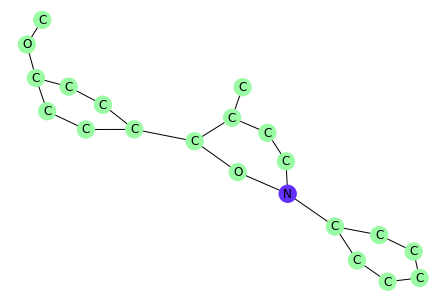

In [9]:
plt.clf()
visualize(training_set[1])

## Preprocessing:

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer

# maximum number of words from the resulting tokenized data which are to be used
max_vocab = 500
max_len = 100


# build vocabulary from training set
all_nodes = [s[0] for s in training_set]
tokenizer = Tokenizer(num_words=max_vocab)
# upadting the internal vocalulary based on the list of text, so it creates the 
# vocabulary index based on word frequnecy so every word gets a unique interger value so lower integers 
# mean more frequent word or nodes.
tokenizer.fit_on_texts(all_nodes)

In [10]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random
random.seed(0)

def prepare_single_batch(samples):
    # loops through samples and saves them as sample_nodes
    sample_nodes = [s[0] for s in samples]
    # convetss each text in sample nodes to a sequence of integers
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes)
    # pads sequence to the same length ﴾all sequences in a list to have the same length﴿, it 
    # does so by padding 0 in the beggining of each sequence until they have the same length as 
    # the longest sequence.
    sample_nodes = pad_sequences(sample_nodes, padding='post')
    # retuns the shape of the array as a tuple
    max_nodes_len = np.shape(sample_nodes)[1]
    # grabs edges by looping through samples (s) and only grabbing the second column [1] elements
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)]
    # make sure the len is not 0 or empty edges
    edges = [e for e in edges if len(e) > 0]
    # grabs nodes by looping through all columns of the sample
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))]
    
    # reshapes all_nodes to a one-shaped dimesion (-1) 
    all_nodes = np.reshape(sample_nodes, -1)
    # joins all edges into a single array
    all_edges = np.concatenate(edges)

    node_to_graph = np.reshape(node_to_graph, -1)
    return {
        'data': all_nodes,
        'edges': all_edges,
        'node2grah': node_to_graph,
    }, np.array([s[2] for s in samples])


# function to generate batch
def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):
    while True:
        # converts dataset to a list of samples
        dataset = list(dataset)
        # if shuffle is set to TRUE, the dataset is shuffled (reorganizes order of items)
        if shuffle:
            random.shuffle(dataset)
        # sets of the length of dataset to new variable 'l'
        l = len(dataset) 
        # loops through the sequence of number from the beginning (0) to the lenth of
        # the dataset (l) and increment by batch size (16 for now)
        for ndx in range(0, l, batch_size):
            # creates batch samples by looping the index data set and using min() to 
            # make sure nothing is out of bound. For example if we're stepping by 16, and
            # hypothetically our dataset is 100 then we could get out of bound errors, therefore
            # using min(1) we can take lesser of the two and avoid that problem
            batch_samples = dataset[ndx:min(ndx + batch_size, l)]
            yield prepare_single_batch(batch_samples)
        if not repeat:
            break


In [11]:
# showing one batch:
for train_batch in gen_batch(training_set, batch_size=4):
    for k,v in train_batch[0].items():
        print(k)
        print(v)
        pass
    print('label', train_batch[1])
    break

data
[4 4 2 2 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 2 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 4 4 8 8 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 5 4 2 2 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
edges
[[  0  12]
 [  1  14]
 [  1  19]
 [  2  38]
 [  2  40]
 [  3  39]
 [  3  41]
 [  4  10]
 [  4  12]
 [  4  13]
 [  5   8]
 [  5  11]
 [  5  12]
 [  6  10]
 [  6  17]
 [  7  11]
 [  7  18]
 [  8  15]
 [  9  14]
 [  9  16]
 [  9  31]
 [ 10  11]
 [ 13  20]
 [ 13  21]
 [ 14  15]
 [ 16  19]
 [ 16  22]
 [ 17  25]
 [ 17  26]
 [ 18  28]
 [ 18  29]
 [ 19  27]
 [ 20  23]
 [ 21  24]
 [ 22  32]
 [ 23  30]
 [ 24  30]
 [ 25  34]
 [ 26  35]
 [ 27  33]
 [ 28  36]
 [ 29  37]
 [ 32  33]
 [ 34  38]
 [ 35  38]
 [ 36  39]
 [ 37  39]
 [ 42  47]
 [ 43  44]
 [ 43  47]
 [ 43  48]
 [ 44  46]
 [ 45  49]
 [ 45  54]
 [ 46  49]
 [ 46  50]
 [ 47  50]
 [ 48  52]
 [ 48  53

In [12]:
!pip install --quiet tf2_gnn

# https://github.com/microsoft/tf2-gnn
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py

from tf2_gnn.layers.gnn import GNN, GNNInput

     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 71kB 6.0MB/s 
     |████████████████████████████████| 194kB 25.6MB/s 
     |████████████████████████████████| 1.1MB 44.7MB/s 
     |████████████████████████████████| 2.6MB 60.0MB/s 


In [13]:
import tensorflow as tf
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam

data = keras.Input(batch_shape=(None,))
print("data:", data)
# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
# this layer can only be used as the first layer in a model. This is the first hidden layer of a 
# network and will learn an embedding for all of the words in the training dataset. Here we are giving 
# it input and output integers
embeded = Embedding(tokenizer.num_words, 20)(data)
print("embeded:", embeded)
# number of graphs (number of samples)
# computes the maximum of elemnts across dimensions 
num_graph = tf.reduce_max(node2graph)+1

# Encode graph states using a combination of graph message passing layers and dense layers
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    # computes graph-level representation given node-level representation (obtained by GNN layer)
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
# gets the default hyperparameter dictionary for the class
params = GNN.get_default_hyperparameters()
# sets the size of the output of all message passing layers
params["hidden_dim"] = 32
params["aggregation_function"] = "sum" # One of sum, mean, max, sqrt_n
params["message_activation_function"] = "relu" # One of relu, leaky_relu, elu, gelu, tanh
params["message_activation_before_aggregation"] = True # Change to True to apply activation _before_ aggregation.
params["num_layers"] = 10

gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
# computes the mean along sements of a tensor
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

data: Tensor("input_4:0", shape=(None,), dtype=float32)
embeded: Tensor("embedding/embedding_lookup/Identity_1:0", shape=(None, 20), dtype=float32)
gnn_out Tensor("gnn/StatefulPartitionedCall:0", shape=(None, 32), dtype=float32)
mean: Tensor("SegmentMean:0", shape=(None, 32), dtype=float32)
pred: Tensor("dense/Sigmoid:0", shape=(None, 1), dtype=float32)
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
tf_op_layer_Max (TensorFlowO

In [14]:
model.compile(
    loss='BinaryCrossentropy',
    optimizer = 'RMSprop',
    metrics=['AUC']
)

In [15]:
import math

batch_size = 100
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=40,
    validation_data=gen_batch(
        validation_set, batch_size=batch_size, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/40


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


213/213 [==============================] - 7s 33ms/step - loss: 0.2918 - auc: 0.4075 - val_loss: 0.2199 - val_auc: 0.5543
Epoch 2/40
213/213 [==============================] - 6s 30ms/step - loss: 0.2073 - auc: 0.5537 - val_loss: 0.1962 - val_auc: 0.6713
Epoch 3/40
213/213 [==============================] - 6s 30ms/step - loss: 0.1955 - auc: 0.6179 - val_loss: 0.2392 - val_auc: 0.6680
Epoch 4/40
213/213 [==============================] - 6s 30ms/step - loss: 0.1923 - auc: 0.6286 - val_loss: 0.2024 - val_auc: 0.6253
Epoch 5/40
213/213 [==============================] - 6s 30ms/step - loss: 0.1876 - auc: 0.6565 - val_loss: 0.1950 - val_auc: 0.6533
Epoch 6/40
213/213 [==============================] - 6s 30ms/step - loss: 0.1852 - auc: 0.6668 - val_loss: 0.1848 - val_auc: 0.6982
Epoch 7/40
213/213 [==============================] - 6s 30ms/step - loss: 0.1850 - auc: 0.6655 - val_loss: 0.2317 - val_auc: 0.6970
Epoch 8/40
213/213 [==============================] - 6s 30ms/step - loss: 0.183

In [34]:
y_pred = model.predict(
    gen_batch(testing_set, batch_size=batch_size, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

In [25]:
len(y_pred)

12326

In [35]:
import pandas as pd 
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('aggregation_sum_100ayers_epoc40_bs100_relu_.csv')